### Обзор данных

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Подключение библиотек и скриптов**

In [1]:
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

In [2]:
import numpy as np
import pandas as pd
import random
import pickle

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import warnings
warnings.simplefilter('ignore')

In [4]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

**Пути к директориям и файлам**

In [5]:
TRAIN_DATASET_PATH = 'G:\Мой диск\dataset\course_project_train.csv'
TEST_DATASET_PATH = 'G:\Мой диск\dataset\course_project_test.csv'

**Загрузка данных**

In [6]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [7]:
df_train.shape

(7500, 17)

In [8]:
df_train.duplicated().sum()

0

In [9]:
df_train.iloc[0]

Home Ownership                            Own Home
Annual Income                             482087.0
Years in current job                           NaN
Tax Liens                                      0.0
Number of Open Accounts                       11.0
Years of Credit History                       26.3
Maximum Open Credit                       685960.0
Number of Credit Problems                      1.0
Months since last delinquent                   NaN
Bankruptcies                                   1.0
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                     99999999.0
Current Credit Balance                     47386.0
Monthly Debt                                7914.0
Credit Score                                 749.0
Credit Default                                   0
Name: 0, dtype: object

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [11]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [12]:
df_test.shape

(2500, 16)

In [13]:
df_test.duplicated().sum()

0

### Обзор данных

**Обзор целевой переменной**

In [14]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

**Обзор количественных признаков**

In [15]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [16]:
df_train['Maximum Open Credit'].value_counts()

0.0         65
319110.0     5
246224.0     3
344058.0     3
513524.0     3
            ..
668360.0     1
642224.0     1
779372.0     1
372812.0     1
480832.0     1
Name: Maximum Open Credit, Length: 6963, dtype: int64

In [17]:
(df_train['Current Loan Amount'] > df_train['Maximum Open Credit']).sum()

2240

In [18]:
df_train['Credit Score'].value_counts()

740.0     169
747.0     168
748.0     157
745.0     152
742.0     151
         ... 
616.0       1
6600.0      1
629.0       1
6820.0      1
6060.0      1
Name: Credit Score, Length: 268, dtype: int64

In [19]:
(df_train['Credit Score'] > 999).sum()

400

**Обзор номинативных признаков**

In [20]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [21]:
for cat_colname in df_test.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_test[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
educational expenses       3
vacation                   3
wedding                    2
moving               

### Обработка выбросов

**Maximum Open Credit**

Заменяем значения в столбце Maximum Open Credit на значения из столбца Current Loan Amount, если первые меньше вторых.

In [22]:
df_train['Maximum Open Credit'].sort_values().unique()

array([0.00000000e+00, 4.33400000e+03, 6.55600000e+03, ...,
       2.65512874e+08, 3.80052288e+08, 1.30472617e+09])

In [23]:
df_train['Current Loan Amount'].sort_values().unique()

array([1.1242000e+04, 2.1472000e+04, 2.1516000e+04, ..., 7.8894200e+05,
       7.8903000e+05, 9.9999999e+07])

In [24]:
(df_train['Current Loan Amount'] > df_train['Maximum Open Credit']).sum()

2240

In [25]:
(df_train['Current Loan Amount'] == df_train['Maximum Open Credit']).sum()

2

In [26]:
num_outliers = df_train.loc[df_train['Current Loan Amount'] > df_train['Maximum Open Credit']].index
num_outliers

Int64Index([   0,    2,    6,    8,    9,   18,   19,   22,   27,   29,
            ...
            7467, 7471, 7475, 7481, 7485, 7487, 7488, 7491, 7495, 7497],
           dtype='int64', length=2240)

In [27]:
df_train.loc[num_outliers, 'Maximum Open Credit'] = df_train.loc[num_outliers, 'Current Loan Amount']

In [28]:
(df_train['Current Loan Amount'] > df_train['Maximum Open Credit']).sum()

0

***Credit Score***

Избавляемся от неадекватных значений Credit Score, разделив значения больше 999 на 10.

In [29]:
df_train['Credit Score'].sort_values().unique()

array([ 585.,  586.,  588.,  589.,  590.,  591.,  593.,  594.,  597.,
        598.,  599.,  601.,  602.,  604.,  606.,  607.,  608.,  609.,
        610.,  611.,  612.,  613.,  614.,  615.,  616.,  617.,  618.,
        619.,  620.,  621.,  622.,  624.,  625.,  626.,  627.,  628.,
        629.,  630.,  631.,  632.,  633.,  634.,  635.,  636.,  637.,
        638.,  639.,  640.,  642.,  643.,  644.,  645.,  646.,  647.,
        648.,  649.,  650.,  651.,  652.,  653.,  654.,  655.,  656.,
        657.,  658.,  659.,  660.,  661.,  662.,  663.,  664.,  665.,
        666.,  667.,  668.,  669.,  670.,  671.,  672.,  673.,  674.,
        675.,  676.,  677.,  678.,  679.,  680.,  681.,  682.,  683.,
        684.,  685.,  686.,  687.,  688.,  689.,  690.,  691.,  692.,
        693.,  694.,  695.,  696.,  697.,  698.,  699.,  700.,  701.,
        702.,  703.,  704.,  705.,  706.,  707.,  708.,  709.,  710.,
        711.,  712.,  713.,  714.,  715.,  716.,  717.,  718.,  719.,
        720.,  721.,

In [30]:
num_score_outliers = df_train.loc[df_train['Credit Score'] > 999].index
num_score_outliers

Int64Index([  69,   87,   94,   96,  116,  152,  153,  198,  217,  263,
            ...
            7353, 7354, 7355, 7364, 7379, 7422, 7433, 7450, 7460, 7496],
           dtype='int64', length=400)

In [31]:
df_train.loc[num_score_outliers, 'Credit Score'] = df_train.loc[num_score_outliers, 'Credit Score'] / 10

In [32]:
(df_train['Credit Score'] > 999).sum()

0

### Обработка пропусков

In [33]:
df_train.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

***Credit Score***

Заменяем пропущенные значения на медиану.

In [34]:
df_train['Credit Score'].sort_values().unique()

array([585., 586., 588., 589., 590., 591., 593., 594., 597., 598., 599.,
       601., 602., 604., 606., 607., 608., 609., 610., 611., 612., 613.,
       614., 615., 616., 617., 618., 619., 620., 621., 622., 623., 624.,
       625., 626., 627., 628., 629., 630., 631., 632., 633., 634., 635.,
       636., 637., 638., 639., 640., 641., 642., 643., 644., 645., 646.,
       647., 648., 649., 650., 651., 652., 653., 654., 655., 656., 657.,
       658., 659., 660., 661., 662., 663., 664., 665., 666., 667., 668.,
       669., 670., 671., 672., 673., 674., 675., 676., 677., 678., 679.,
       680., 681., 682., 683., 684., 685., 686., 687., 688., 689., 690.,
       691., 692., 693., 694., 695., 696., 697., 698., 699., 700., 701.,
       702., 703., 704., 705., 706., 707., 708., 709., 710., 711., 712.,
       713., 714., 715., 716., 717., 718., 719., 720., 721., 722., 723.,
       724., 725., 726., 727., 728., 729., 730., 731., 732., 733., 734.,
       735., 736., 737., 738., 739., 740., 741., 74

In [35]:
condition_score = (df_train['Credit Score'].isna())
df_train.loc[condition_score, 'Credit Score'] = df_train['Credit Score'].median()

***Annual Income***

Заменяем пропущенные значения на медиану.

In [36]:
df_train['Annual Income'].sort_values().unique()

array([  164597.,   175845.,   177251., ...,  9338880., 10149344.,
             nan])

In [37]:
condition_income = (df_train['Annual Income'].isna())
df_train.loc[condition_income, 'Annual Income'] = df_train['Annual Income'].median()

***Bankruptcies***

Заменяем пропущенные значения на медиану.

In [38]:
df_train['Bankruptcies'].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4., nan])

In [39]:
condition_bankruptcies = (df_train['Bankruptcies'].isna())
df_train.loc[condition_bankruptcies, 'Bankruptcies'] = df_train['Bankruptcies'].median()

***Years in current job***

Заменяем пропущенные значения на моду.

In [40]:
df_train['Years in current job'].sort_values().unique()

array(['1 year', '10+ years', '2 years', '3 years', '4 years', '5 years',
       '6 years', '7 years', '8 years', '9 years', '< 1 year', nan],
      dtype=object)

In [41]:
condition_job = (df_train['Years in current job'].isna())
df_train.loc[condition_job, 'Years in current job'] = df_train['Years in current job'].mode()[0]

***Months since last delinquent***

Удаляем столбец Months since last delinquent, т.к. в нем слишком много пропущенных значений.

In [42]:
df_train.drop('Months since last delinquent', axis=1, inplace=True)

In [43]:
df_train.isna().sum()

Home Ownership               0
Annual Income                0
Years in current job         0
Tax Liens                    0
Number of Open Accounts      0
Years of Credit History      0
Maximum Open Credit          0
Number of Credit Problems    0
Bankruptcies                 0
Purpose                      0
Term                         0
Current Loan Amount          0
Current Credit Balance       0
Monthly Debt                 0
Credit Score                 0
Credit Default               0
dtype: int64

In [44]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.years_in_current_job_mode = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.years_in_current_job_mode = X['Years in current job'].mode()[0]
    
    def transform(self, X):
        """Трансформация данных"""
        
        # Maximum Open Credit             
        num_outliers = X.loc[X['Current Loan Amount'] > X['Maximum Open Credit']].index
        X.loc[num_outliers, 'Maximum Open Credit'] = X.loc[num_outliers, 'Current Loan Amount']
                
        # Credit Score                
        num_score_outliers = X.loc[X['Credit Score'] > 999].index
        X.loc[num_score_outliers, 'Credit Score'] = X.loc[num_score_outliers, 'Credit Score'] / 10
        
        condition_score = (X['Credit Score'].isna())
        X.loc[condition_score, 'Credit Score'] = self.medians['Credit Score']
                  
        # Annual Income
        condition_income = (X['Annual Income'].isna())
        X.loc[condition_income, 'Annual Income'] = self.medians['Annual Income']
                       
        # Bankruptcies
        condition_bankruptcies = (X['Bankruptcies'].isna())
        X.loc[condition_bankruptcies, 'Bankruptcies'] = self.medians['Bankruptcies']
                
        # Years in current job
        condition_job = (X['Years in current job'].isna())
        X.loc[condition_job, 'Years in current job'] = self.years_in_current_job_mode
                    
        # Months since last delinquent
        if 'Months since last delinquent' in X.columns:
            X.drop('Months since last delinquent', axis=1, inplace=True)
        
        
        return X

### Построение новых признаков

**Dummies**

In [45]:
binary_to_numbers = {'Short Term': 0, 'Long Term': 1}
df_train['Term num'] = df_train['Term'].map(binary_to_numbers).astype(int)
df_train.drop('Term', axis=1, inplace=True)

In [46]:
df_train['Purpose'] = np.where(df_train['Purpose'] == 'debt consolidation', 0, 1)

In [47]:
df_train['Purpose'].value_counts()

0    5944
1    1556
Name: Purpose, dtype: int64

In [48]:
df_train.rename(columns = {'Purpose':'Purpose num'}, inplace = True )

In [49]:
df_train.loc[df_train['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'

In [50]:
df_train['Home Ownership'].value_counts()

Home Mortgage    3649
Rent             3204
Own Home          647
Name: Home Ownership, dtype: int64

In [51]:
categories = ['Home Ownership', 'Years in current job']
names = ['Ownership', 'Job']
df_train = pd.get_dummies(df_train, columns=categories, prefix=names, prefix_sep=' ', drop_first=False)

In [52]:
df_train.shape

(7500, 28)

In [53]:
df_train.rename(columns = {'Job 10+ years':'Job 10 years', 'Job < 1 year':'Job 0 year'}, inplace = True)

**Приведение типов**

In [54]:
for colname in ['Ownership Home Mortgage', 'Ownership Own Home', 'Ownership Rent', 'Job 1 year', 'Job 10 years', 'Job 2 years',
                'Job 3 years', 'Job 4 years', 'Job 5 years', 'Job 6 years', 'Job 7 years', 'Job 8 years', 'Job 9 years',
                'Job 0 year']:
    df_train[colname] = df_train[colname].astype(int)

In [55]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Annual Income              7500 non-null   float64
 1   Tax Liens                  7500 non-null   float64
 2   Number of Open Accounts    7500 non-null   float64
 3   Years of Credit History    7500 non-null   float64
 4   Maximum Open Credit        7500 non-null   float64
 5   Number of Credit Problems  7500 non-null   float64
 6   Bankruptcies               7500 non-null   float64
 7   Purpose num                7500 non-null   int32  
 8   Current Loan Amount        7500 non-null   float64
 9   Current Credit Balance     7500 non-null   float64
 10  Monthly Debt               7500 non-null   float64
 11  Credit Score               7500 non-null   float64
 12  Credit Default             7500 non-null   int64  
 13  Term num                   7500 non-null   int32

In [56]:
class FeatureGenetator():
    """Генерация новых признаков"""
    
    def __init__(self):
        self.binary_to_numbers = None
        self.categories = None
        self.names = None
        
                
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'Short Term': 0, 'Long Term': 1}
        
        # Categorical features
        self.categories = ['Home Ownership', 'Purpose', 'Years in current job']
        self.names = ['Ownership', 'Purpose', 'Job']
                
    def transform(self, X):
                                       
        # Binary features
        X['Term num'] = X['Term'].map(binary_to_numbers).astype(int)
        X.drop('Term', axis=1, inplace=True)
                
        # Categorical features
        X['Purpose'] = np.where(X['Purpose'] == 'debt consolidation', 0, 1)
        X.rename(columns = {'Purpose':'Purpose num'}, inplace = True )
        
        X.loc[X['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
        
        X = pd.get_dummies(X, columns=categories, prefix=names, prefix_sep=' ')
        X.rename(columns = {'Job 10+ years':'Job 10 years', 'Job < 1 year':'Job 0 year'}, inplace = True)
                     
        # Приведение типов
        for colname in ['Ownership Home Mortgage', 'Ownership Own Home', 'Ownership Rent', 'Job 1 year', 'Job 10 years',
                        'Job 2 years', 'Job 3 years', 'Job 4 years', 'Job 5 years', 'Job 6 years', 'Job 7 years',
                        'Job 8 years', 'Job 9 years', 'Job 0 year']:
            X[colname] = X[colname].astype(int)
                                        
        
        return X

### Анализ целевой переменной

**Выделение целевой переменной и групп признаков**

In [57]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                      'Number of Credit Problems', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
                      'Monthly Debt', 'Credit Score']
NEW_FEATURE_NAMES = ['Term num', 'Ownership Home Mortgage', 'Ownership Own Home', 'Ownership Rent', 'Purpose num', 'Job 1 year',
                     'Job 10 years', 'Job 2 years', 'Job 3 years', 'Job 4 years', 'Job 5 years', 'Job 6 years', 'Job 7 years',
                     'Job 8 years', 'Job 9 years', 'Job 0 year']

**Обзор распределения**

In [58]:
df_train[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

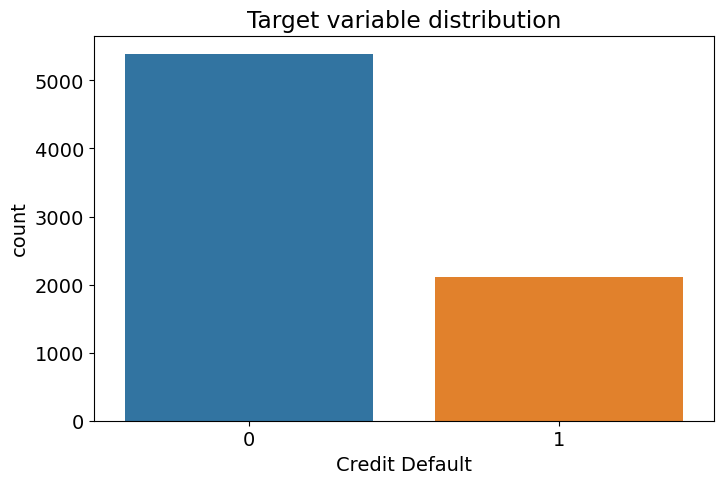

In [59]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df_train)

plt.title('Target variable distribution')
plt.show()

**Корреляция с базовыми признаками**

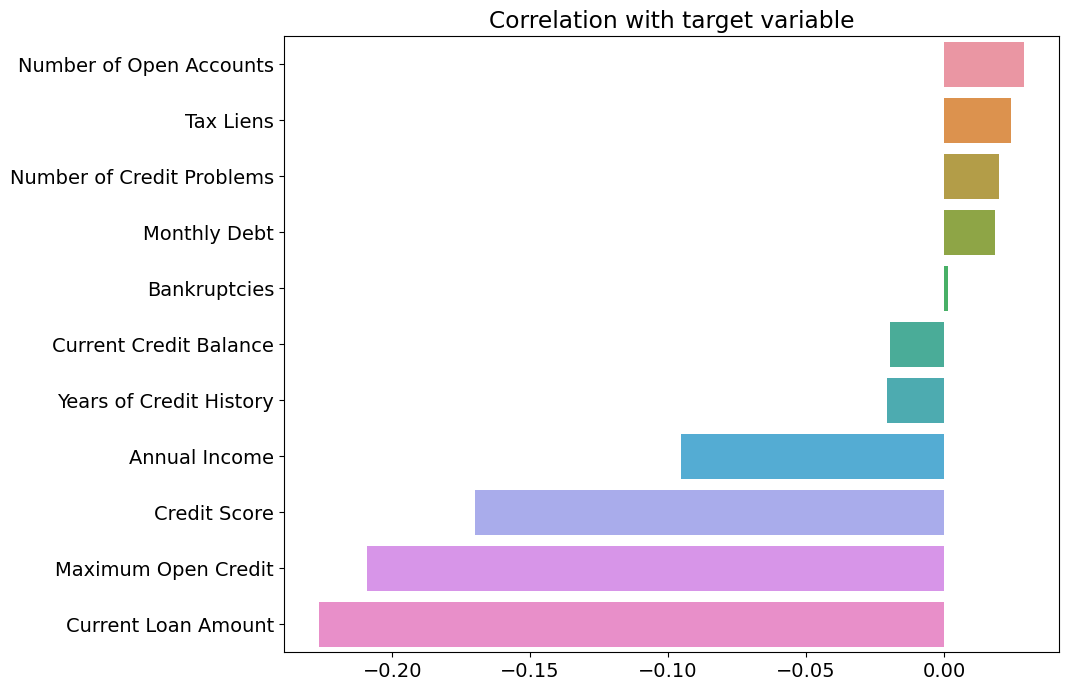

In [60]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

**Корреляция с новыми признаками**

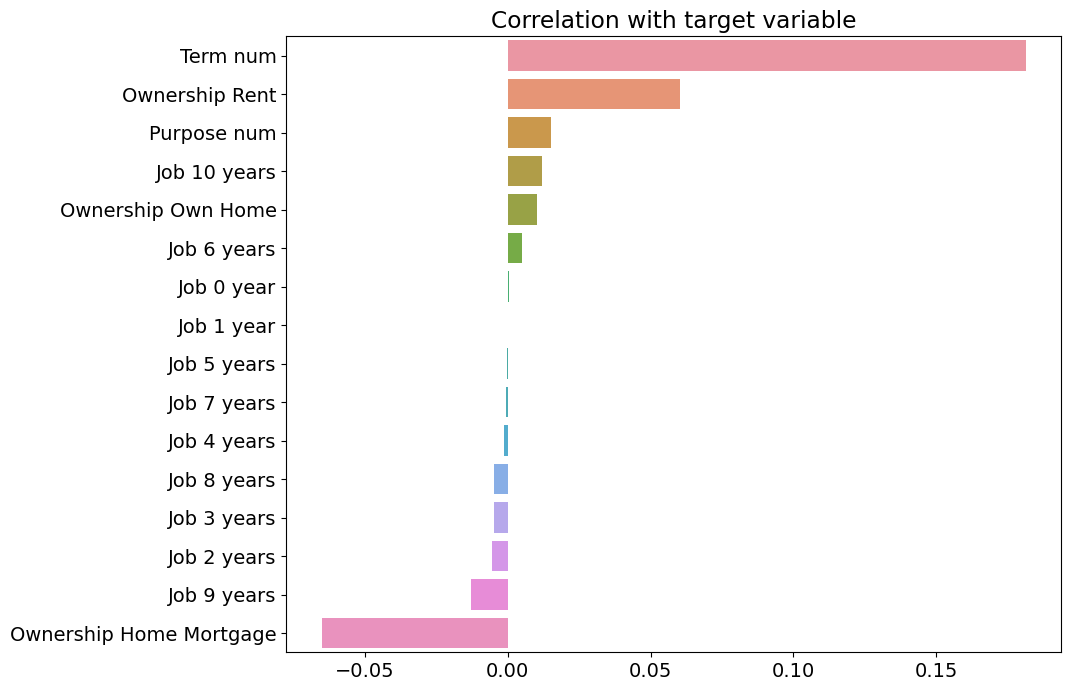

In [61]:
corr_with_target = df_train[NEW_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

### Анализ признакового пространства

**Матрица корреляций**

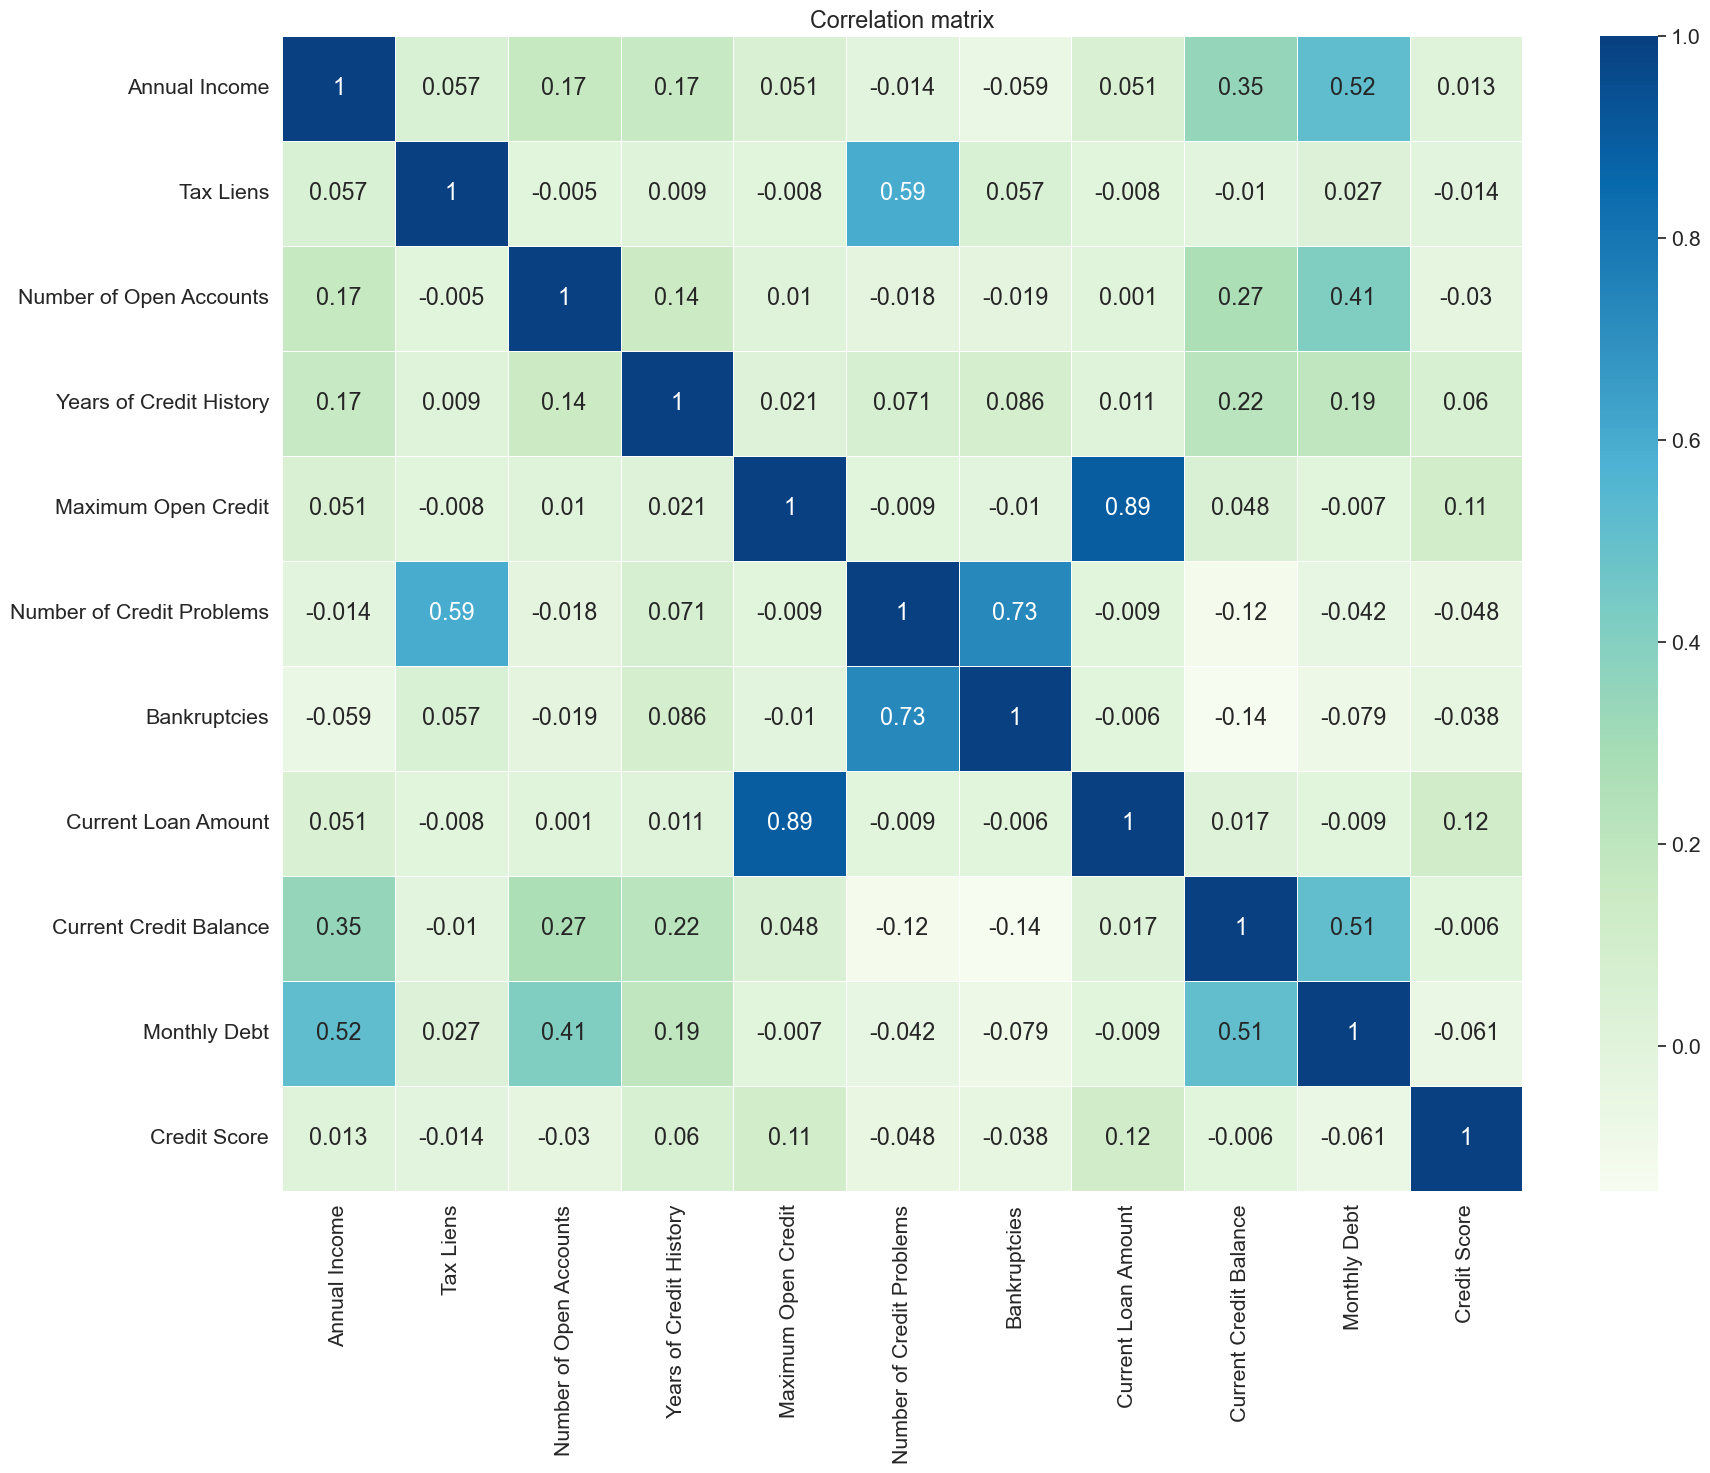

In [62]:
plt.figure(figsize = (20,15))

sns.set(font_scale=1.4)
sns.heatmap(df_train[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### Отбор признаков

In [63]:
df_train.columns.tolist()

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Bankruptcies',
 'Purpose num',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default',
 'Term num',
 'Ownership Home Mortgage',
 'Ownership Own Home',
 'Ownership Rent',
 'Job 1 year',
 'Job 10 years',
 'Job 2 years',
 'Job 3 years',
 'Job 4 years',
 'Job 5 years',
 'Job 6 years',
 'Job 7 years',
 'Job 8 years',
 'Job 9 years',
 'Job 0 year']

In [64]:
NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                     'Number of Credit Problems', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
                     'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['Term', 'Home Ownership', 'Purpose', 'Years in current job']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + NEW_FEATURE_NAMES

### Нормализация данных

In [65]:
scaler = StandardScaler()

df_norm = df_train.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df_train = df_norm.copy()

**Сохранение модели для нормализации данных**

In [66]:
with open('SCALER_FILE_PATH', 'wb') as file:
    pickle.dump(scaler, file)

### Разбиение на train и test

In [67]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)


X = df_train.drop(columns=TARGET_NAME)
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

***Обработка выбросов и пропусков***

In [68]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)
df_test = preprocessor.transform(df_test)

X_train.shape, X_test.shape, df_test.shape

((5250, 15), (2250, 15), (2500, 15))

In [69]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_test = features_gen.transform(X_test)
df_test = features_gen.transform(df_test)

X_train.shape, X_test.shape, df_test.shape

((5250, 27), (2250, 27), (2500, 27))

In [70]:
X_train = X_train[SELECTED_FEATURE_NAMES]
X_test = X_test[SELECTED_FEATURE_NAMES]
df_test = df_test[SELECTED_FEATURE_NAMES]

In [71]:
X_train.isna().sum().sum(), X_test.isna().sum().sum(), df_test.isna().sum().sum()

(0, 0, 0)

### Балансировка целевой переменной

In [72]:
def balance_df_train_by_target(df_train, target_name):

    target_counts = df_train[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df_train[df_train[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df_train = df_train.append(sample, ignore_index=True)

    return df_train.sample(frac=1)

In [73]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_train_balanced = balance_df_train_by_target(df_for_balancing, TARGET_NAME)
    
df_train_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [74]:
X_train = df_train_balanced.drop(columns=TARGET_NAME)
y_train = df_train_balanced[TARGET_NAME]

### Сохранение обучающего и тестового датасетов

In [75]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [76]:
df_train.to_csv('TRAIN_FULL_PATH', index=False, encoding='utf-8')
train.to_csv('TRAIN_PART_PATH', index=False, encoding='utf-8')
test.to_csv('TEST_PART_PATH', index=False, encoding='utf-8')

### Построение и оценка базовых моделей

In [77]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

**Логистическая регрессия**

In [78]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.63      0.75      0.68      3771
           1       0.58      0.44      0.50      2958

    accuracy                           0.61      6729
   macro avg       0.60      0.59      0.59      6729
weighted avg       0.61      0.61      0.60      6729

TEST

              precision    recall  f1-score   support

           0       0.76      0.73      0.75      1616
           1       0.37      0.41      0.39       634

    accuracy                           0.64      2250
   macro avg       0.57      0.57      0.57      2250
weighted avg       0.65      0.64      0.65      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1183  433
1                375  259


**k ближайших соседей**

In [79]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.80      0.79      3771
           1       0.74      0.72      0.73      2958

    accuracy                           0.76      6729
   macro avg       0.76      0.76      0.76      6729
weighted avg       0.76      0.76      0.76      6729

TEST

              precision    recall  f1-score   support

           0       0.76      0.68      0.72      1616
           1       0.36      0.46      0.40       634

    accuracy                           0.62      2250
   macro avg       0.56      0.57      0.56      2250
weighted avg       0.65      0.62      0.63      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1092  524
1                340  294


***Бустинговые алгоритмы***

**XGBoost**

In [80]:
model_xgb = xgb.XGBClassifier(booster='dart', random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3771
           1       0.98      0.98      0.98      2958

    accuracy                           0.98      6729
   macro avg       0.98      0.98      0.98      6729
weighted avg       0.98      0.98      0.98      6729

TEST

              precision    recall  f1-score   support

           0       0.77      0.78      0.77      1616
           1       0.41      0.40      0.40       634

    accuracy                           0.67      2250
   macro avg       0.59      0.59      0.59      2250
weighted avg       0.67      0.67      0.67      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1254  362
1                383  251


**LightGBM**

In [81]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      3771
           1       0.90      0.91      0.90      2958

    accuracy                           0.91      6729
   macro avg       0.91      0.91      0.91      6729
weighted avg       0.91      0.91      0.91      6729

TEST

              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1616
           1       0.43      0.46      0.44       634

    accuracy                           0.67      2250
   macro avg       0.60      0.61      0.61      2250
weighted avg       0.68      0.67      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1228  388
1                345  289


**CatBoost**

In [82]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      3771
           1       0.88      0.88      0.88      2958

    accuracy                           0.89      6729
   macro avg       0.89      0.89      0.89      6729
weighted avg       0.89      0.89      0.89      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.77      0.78      1616
           1       0.44      0.47      0.46       634

    accuracy                           0.68      2250
   macro avg       0.61      0.62      0.62      2250
weighted avg       0.69      0.68      0.69      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1237  379
1                334  300


### Выбор лучшей модели и подбор гиперпараметров

In [83]:
model_catb = catb.CatBoostClassifier(cat_features=None, class_weights=[1, 3.5], silent=True, random_state=21)

**Подбор гиперпараметров**

In [84]:
parameters = {'depth':[2, 3, 4, 5, 6, 7],
              'learning_rate':[0.01, 0.02, 0.03, 0.04], 
              'iterations':[ 50, 100, 200, 500, 700, 1000, 1200],
              'l2_leaf_reg': [1, 3, 5, 7, 9]}

In [85]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [86]:
#%%time

#gs = GridSearchCV(estimator=model_catb, param_grid = parameters, scoring='f1', cv = cv, n_jobs=-1)
#gs.fit(X_train, y_train)

Wall time: 21min 30s


GridSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x000001C7DD3CA3D0>,
             n_jobs=-1,
             param_grid={'depth': [2, 3, 4, 5, 6, 7],
                         'iterations': [50, 100, 200, 500, 700, 1000, 1200],
                         'l2_leaf_reg': [1, 3, 5, 7, 9],
                         'learning_rate': [0.01, 0.02, 0.03, 0.04]},
             scoring='f1')

In [87]:
#gs.best_params_

{'depth': 7, 'iterations': 1200, 'l2_leaf_reg': 1, 'learning_rate': 0.04}

In [88]:
#gs.best_score_

0.7361342320046423

**Обучение и оценка финальной модели**

Используем полученные параметры: best_params_ {'depth': 7, 'iterations': 1200, 'l2_leaf_reg': 1, 'learning_rate': 0.04}, best_score_  0.7361342320046423

In [89]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=1200, learning_rate=0.04, depth=7, 
                                      l2_leaf_reg=1, silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3771
           1       1.00      1.00      1.00      2958

    accuracy                           1.00      6729
   macro avg       1.00      1.00      1.00      6729
weighted avg       1.00      1.00      1.00      6729

TEST

              precision    recall  f1-score   support

           0       0.77      0.82      0.79      1616
           1       0.44      0.36      0.40       634

    accuracy                           0.69      2250
   macro avg       0.60      0.59      0.60      2250
weighted avg       0.67      0.69      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1329  287
1                406  228
Wall time: 5.68 s


*Кросс-валидация*

In [90]:
cv_score = cross_val_score(final_model, X_train, y_train, scoring='f1', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.78121975, 0.78456277, 0.77665219])

In [91]:
cv_score.mean()

0.7808115726616407

### Снижение степени переобучения

Уменьшаем глубину дерева и число итераций, а значение коэффициента при члене регуляризации L2 функции потерь увеличиваем.

In [105]:
final_model = catb.CatBoostClassifier(n_estimators=700, learning_rate=0.04, depth=2,
                                      l2_leaf_reg=10, silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.75      0.74      3771
           1       0.67      0.63      0.65      2958

    accuracy                           0.70      6729
   macro avg       0.70      0.69      0.70      6729
weighted avg       0.70      0.70      0.70      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.71      0.76      1616
           1       0.44      0.57      0.50       634

    accuracy                           0.67      2250
   macro avg       0.62      0.64      0.63      2250
weighted avg       0.70      0.67      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1151  465
1                272  362


### Выбор порога вероятности для определения класса

In [106]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

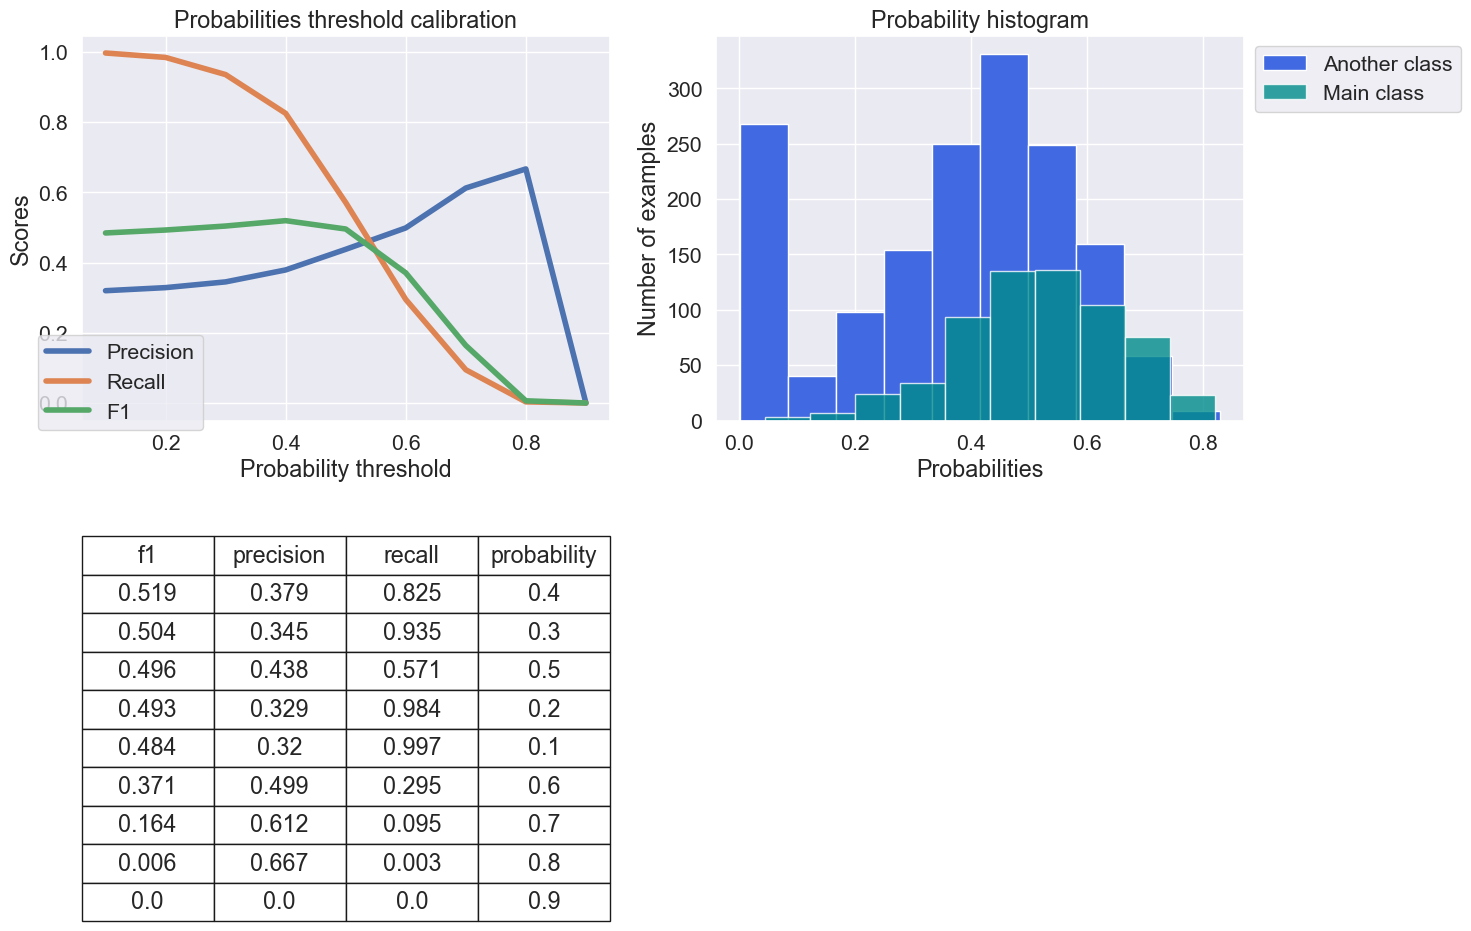

In [107]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

### Важность признаков

In [108]:
feature_importances = pd.DataFrame(zip(X_train.columns, final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
7,Current Loan Amount,36.777807
4,Maximum Open Credit,32.154326
0,Annual Income,6.152672
10,Credit Score,5.759032
11,Term num,4.970216
9,Monthly Debt,3.414633
3,Years of Credit History,2.959479
8,Current Credit Balance,2.788115
2,Number of Open Accounts,1.843736
12,Ownership Home Mortgage,0.948391


### Сохранение финальной модели

In [109]:
with open('MODEL_FILE_PATH', 'wb') as file:
    pickle.dump(final_model, file)

### Прогнозирование на тестовом датасете

In [110]:
df_test.shape

(2500, 27)

In [111]:
predictions = final_model.predict(df_test)
predictions

array([0, 1, 0, ..., 1, 0, 1], dtype=int64)

In [112]:
prediction = pd.DataFrame(predictions, columns=['Credit Default']).to_csv('VVSpirova_predictions.csv',
                                                                          index=False, encoding='utf-8')

In [113]:
submit = 'G:\Мой диск\dataset\VVSpirova_predictions.csv'

In [114]:
sub = pd.read_csv(submit)
sub

,Credit Default
0,0
1,1
2,0
3,0
4,0
...,...
2495,0
2496,1
2497,1
2498,0
